# Disc Golf Disc Classifier
> Deep Learning Image Recognition App using FastAI

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

Live App is running at https://udisc.mattlichti.com/

All the data was submitted through the Udisc Android & iPhone apps https://udisc.com/

The code is based on lessons 1 & 2 of fastai course 3 https://course.fast.ai/

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
import urllib.request as req
import pandas as pd
import os
import numpy as np

## **Step 1: Cleaning the Data and loading it into the fastai ImageDataBunch class**

In [3]:
df = pd.read_csv('transformed_97_discs.csv', index_col=0)

In [4]:
df = df.loc[df.downloaded]
df = df.loc[df['size']>=25000]
df.shape

(63815, 13)

In [6]:
np.random.seed(42)
df = df[df['discName'].isin(['Leopard', 'Buzzz', 'Firebird'])]
df = df.sample(3000)
df.groupby('discName').count()

manufacturerName  image  plastic  created  type  speed  size  \
discName                                                                 
Buzzz                 1168   1168      967     1168  1158    839  1168   
Firebird               786    786      755      786   778    715   786   
Leopard               1046   1046      834     1046  1040   1006  1046   

          downloaded  disc_label  plastic_label  folder  path  
discName                                                       
Buzzz           1168        1168           1168    1168  1168  
Firebird         786         786            786     786   786  
Leopard         1046        1046           1046    1046  1046

In [7]:
df.index = df.path
df = df.loc[:, ['disc_label']]
df.to_csv('disc_images/labels.csv')

In [9]:
np.random.seed(42)
path = Path('/home/jupyter/disc_classifier/disc_images')
data = ImageDataBunch.from_csv(path, valid_pct=.1,
        ds_tfms=get_transforms(do_flip=False), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data.classes, len(data.train_ds), len(data.valid_ds)

(['Discraft Buzzz', 'Innova Firebird', 'Innova Leopard'], 2700, 300)

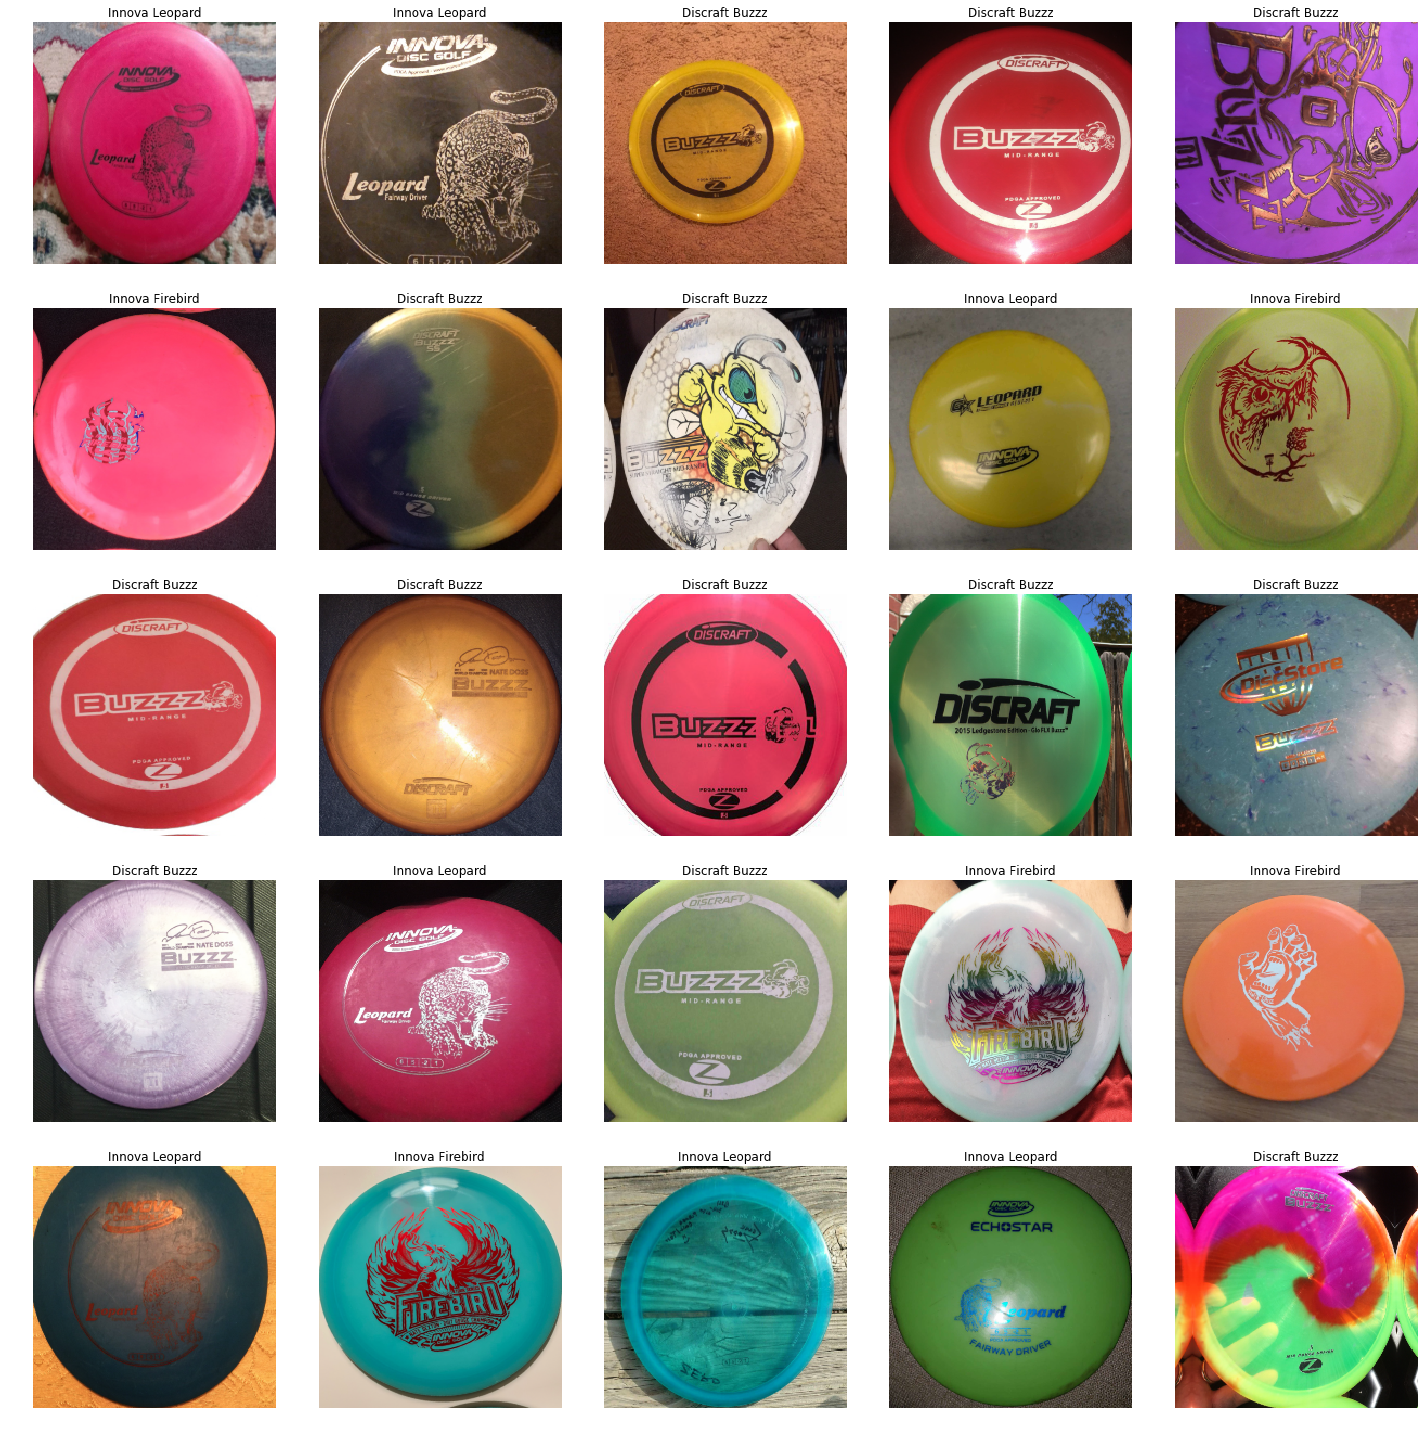

In [11]:
data.show_batch()

## **Step 2: Training the Convolutional Neural Net.** 
We use a 50 layer ResNet that has been pretrained on ImageNet. https://en.wikipedia.org/wiki/Residual_neural_network 

In [13]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


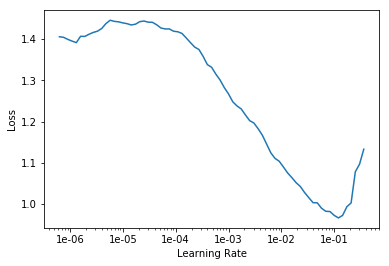

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, max_lr=3*1e-3)

In [17]:
learn.save('3_discs-1-4')

## **Step 3: Interpreting the Results**

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

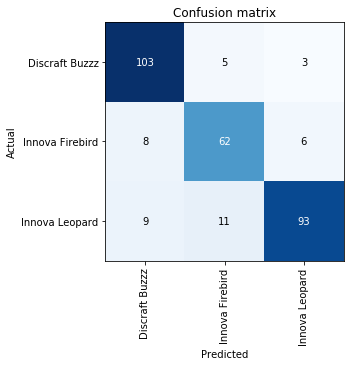

In [19]:
interp.plot_confusion_matrix(figsize=(5,5))

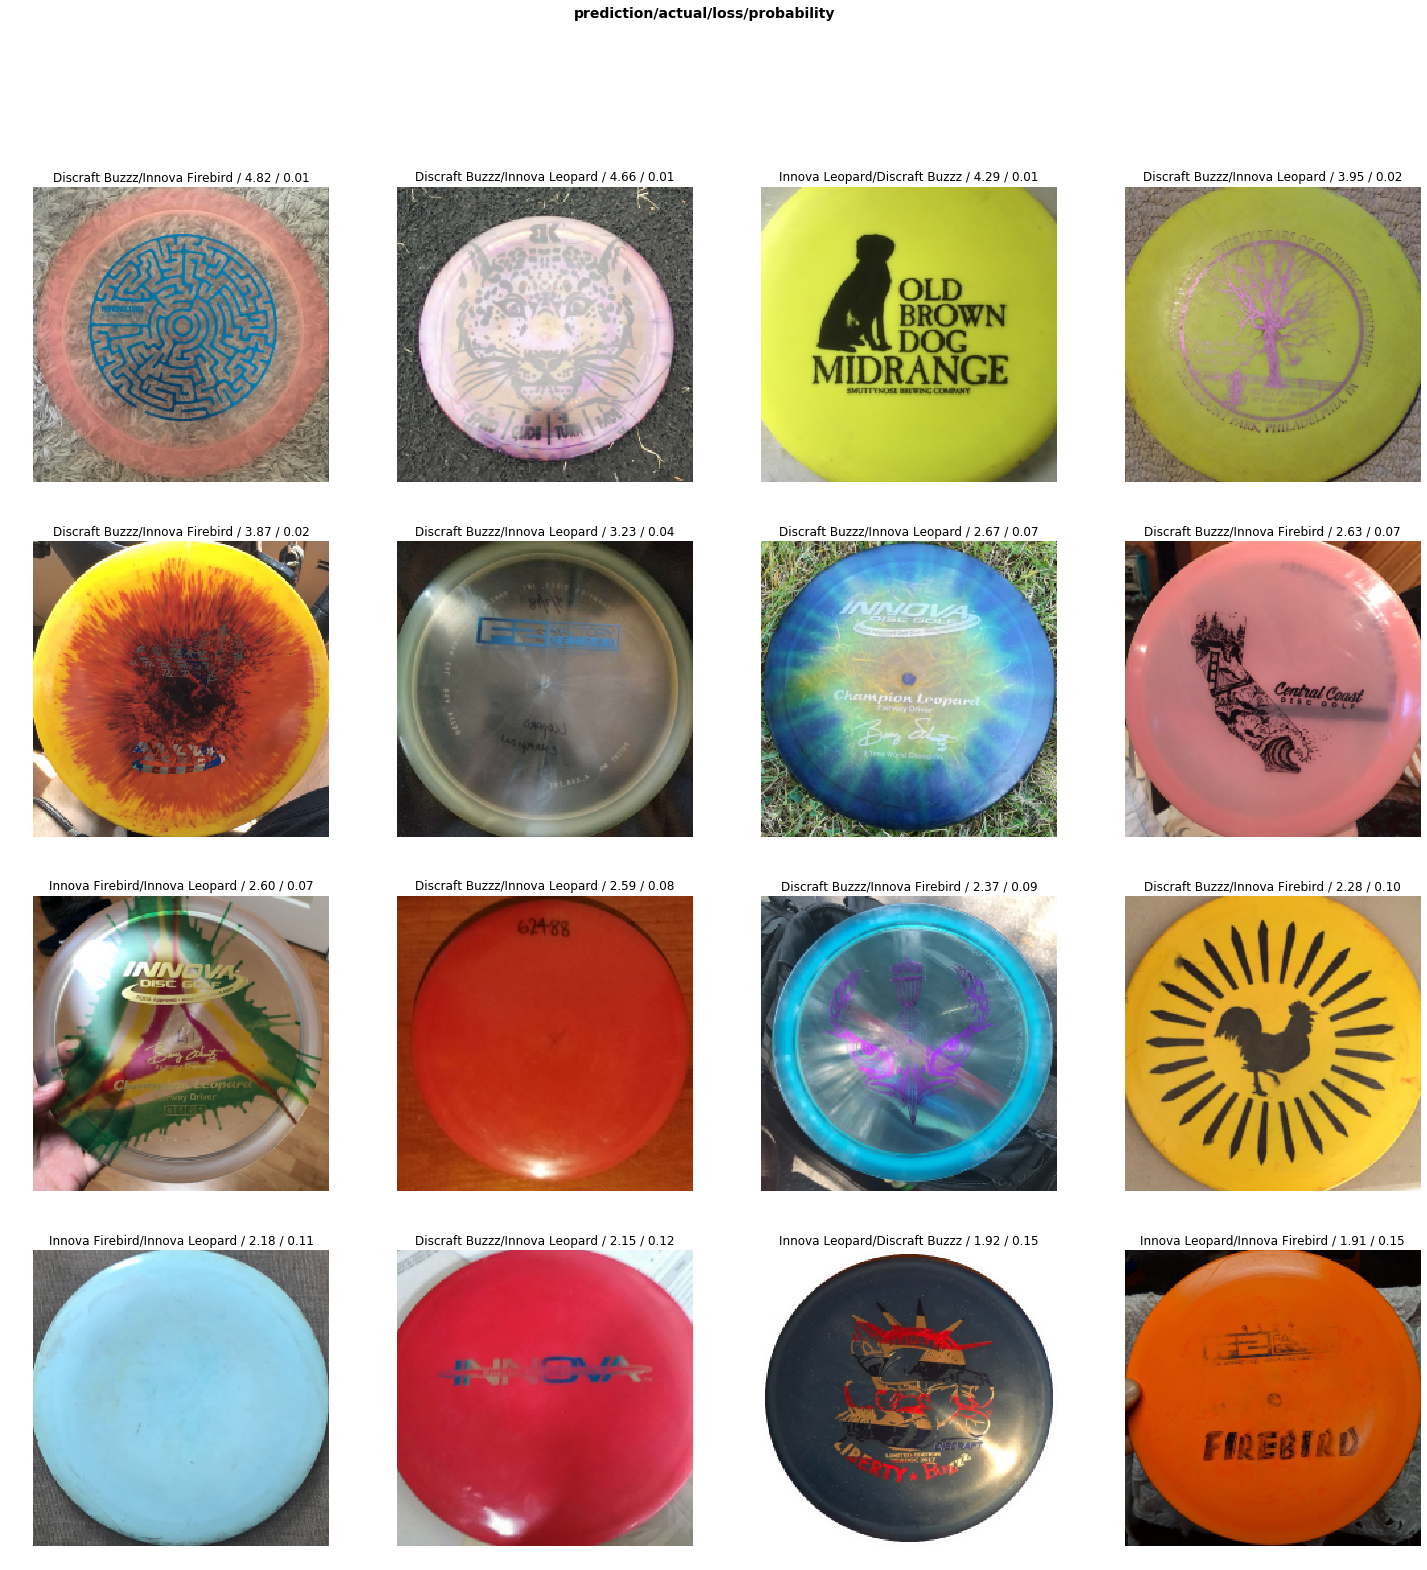

In [20]:
interp.plot_top_losses(16, figsize=(25,25), heatmap=False)

**Step 4 (optional): Train more layers of the neural net to improve performance**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


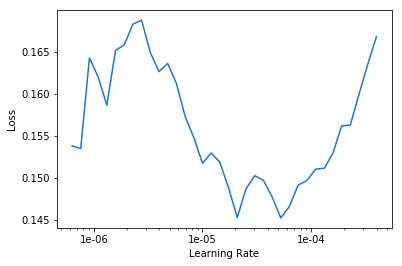

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(3, max_lr=slice(5*1e-5,3*1e-4))

In [23]:
learn.save('3_discs-2-3')

In [25]:
interp = ClassificationInterpretation.from_learner(learn)


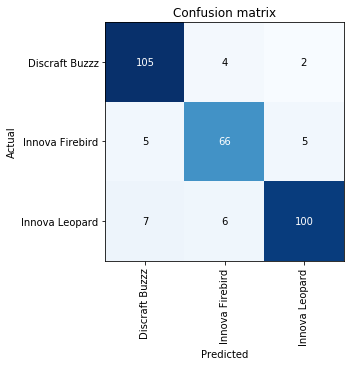

In [26]:
interp.plot_confusion_matrix(figsize=(5,5))

**Step 5: Putting in to production**

In [27]:
defaults.device = torch.device('cpu')

In [29]:
path = Path('/home/jupyter/disc_classifier/disc_images')
data = ImageDataBunch.from_csv(path, valid_pct=.1,
        ds_tfms=get_transforms(flip_vert=True), size=224, num_workers=4).normalize(imagenet_stats)   
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [1]:
# learn.load('3_discs-2-3')

In [31]:
path = Path('/home/jupyter/disc_classifier/')
leopard = open_image(path/'leopard.jpeg')

In [32]:
leopard = open_image(path/'leopard.jpeg')

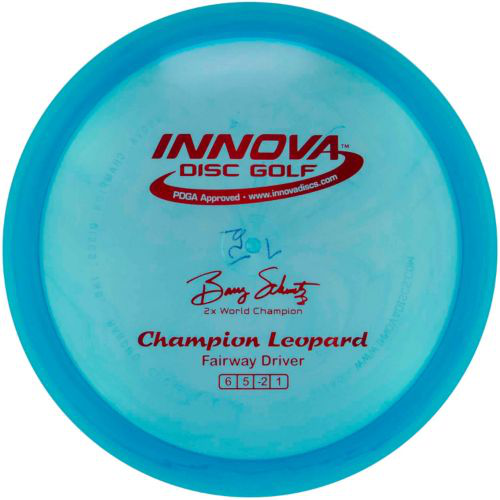

In [33]:
leopard

In [34]:
pred_class,pred_idx,outputs = learn.predict(leopard)

In [35]:
pred_class

Category Innova Leopard

In [36]:
outputs

tensor([1.3064e-05, 7.1869e-04, 9.9927e-01])

In [37]:
data.classes

['Discraft Buzzz', 'Innova Firebird', 'Innova Leopard']

In [38]:
learn.export('3discs.pkl')

In [39]:
def predict_disc(learn, img):
    pred_class,pred_idx,outputs = learn.predict(img)
    idx = np.argsort(-outputs)[0]
    if outputs[idx].item()>.75:
        output = 'We think your disc is: ' + str(pred_class)
    else:
        output = "Sorry, we aren't sure what kind of disc that is."
    output += '\nTop disc mold probabilities for your disc: \n' 
    for idx in np.argsort(-outputs)[:10]:
        if outputs[idx].item()>.00005:
            output += str(data.classes[idx]) + ': '
            output += str(round(outputs[idx].item()*100,2)) + '%' + '\n'
    return(output)

In [40]:
print(predict_disc(learn, leopard))

We think your disc is: Innova Leopard
Top disc mold probabilities for your disc: 
Innova Leopard: 99.93%
Innova Firebird: 0.07%



In [41]:
firebird = open_image(path/'firebird.jpg')

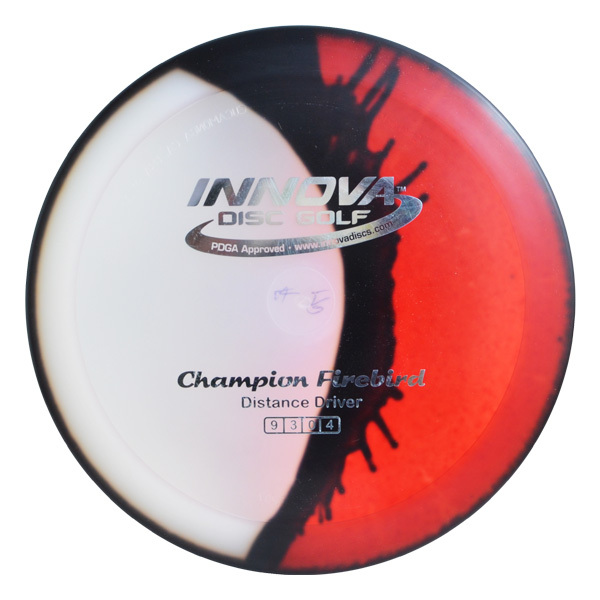

In [42]:
firebird

In [43]:
print(predict_disc(learn, firebird))

We think your disc is: Innova Leopard
Top disc mold probabilities for your disc: 
Innova Leopard: 97.34%
Innova Firebird: 1.98%
Discraft Buzzz: 0.68%

